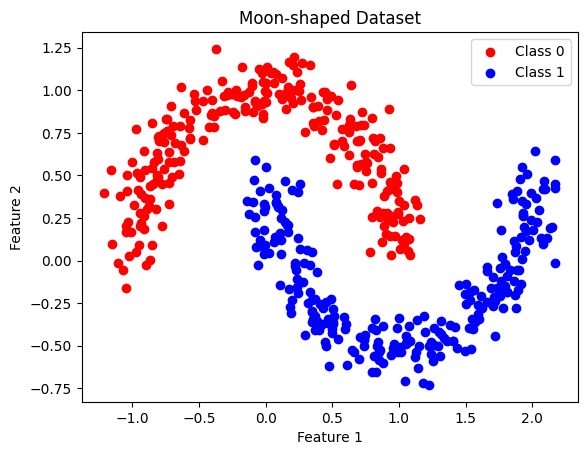

In [721]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np

np.random.seed(42)
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

original_y = y.copy()
for i in range(len(y)):  # polarizing output
    y[i] = 1.0 if y[i] == 1 else -1.0


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)
plt.scatter(
    X[original_y == 0][:, 0],
    X[original_y == 0][:, 1],
    color="red",
    label="Class 0",
)
plt.scatter(
    X[original_y == 1][:, 0],
    X[original_y == 1][:, 1],
    color="blue",
    label="Class 1",
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Moon-shaped Dataset")


def plot_decesion_boundary(model):
    xx, yy = np.meshgrid(
        np.linspace(X.min() - 0.1, X.max() + 0.1, 500),
        np.linspace(y.min() - 1, y.max() + 1, 500),
    )
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], s=20, color="red", label="Class 0")
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], s=20, color="blue", label="Class 1")

    plt.legend()

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

In [722]:
class MadaLineMR1:
    def __init__(self, X_train, X_test, y_train, y_test, layer_sizes: tuple) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        # layer_sizes = (2, 3, 1) for example
        self._weights = []
        self._biases = []

        for i in range(len(layer_sizes) - 1):
            self._weights.append([])
            for j in range(layer_sizes[i + 1]):
                if i != len(layer_sizes) - 1 - 1:  # not the last layer
                    self._weights[i].append(np.random.random(layer_sizes[i]))
                else:  # in MR1 all last layer weights are 0.5
                    self._weights[i].append(
                        np.full((layer_sizes[i]), 1 / layer_sizes[i])
                    )

            if i != len(layer_sizes) - 1 - 1:
                self._biases.append(np.random.random(layer_sizes[i + 1]))
            else:  # weights = 1 / n and bias = (n-2)/n
                self._biases.append(np.array([(layer_sizes[i] - 2) / layer_sizes[i]]))

    def fit(self, alpha: float, max_loss: float, epochs: int):
        losses = []
        test_losses = []
        for epoch in range(epochs):
            test_errors = []
            errors = []
            for i in range(self.X_train.shape[0]):
                unactivated_z = (
                    np.dot(self._weights[0], self.X_train[i]) + self._biases[0]
                )

                z = np.array([1.0 if z_in >= 0 else -1.0 for z_in in unactivated_z])

                unactivated_y = np.dot(self._weights[1], z) + self._biases[1]
                y = np.array([1.0 if y_in >= 0 else -1.0 for y_in in unactivated_y])

                # if (y == -1):
                #     print(y)
                error = 0.5 * ((self.y_train[i] - y) ** 2)
                errors.append(error)
                if self.y_train[i] == y:
                    # print("Equal, Continue...")
                    continue
                elif self.y_train[i] == 1:
                    # print("Not Equal, 1...")
                    j = 0
                    for k in range(len(unactivated_z)):
                        if unactivated_z[j] > unactivated_z[k]:# find the minimum distance index
                            j = k
                    self._weights[0][j] += (
                        alpha * (self.y_train[i] - y) * self.X_train[i]
                    )
                    self._biases[0][j] += alpha * (self.y_train[i] - y[0])

                elif self.y_train[i] == -1:
                    # print("Not Equal, -1...")
                    for k in range(len(unactivated_z)):
                        if unactivated_z[k] >= 0:
                            self._weights[0][k] += (
                                alpha * (self.y_train[i] - y) * self.X_train[i]
                            )
                            self._biases[0][k] += alpha * (self.y_train[i] - y[0])

            loss = np.mean(errors)
            losses.append(loss)

            if loss < max_loss:
                print(f"Done, Epochs: {epoch} | Loss: {loss}")
                break
            for i in range(self.X_test.shape[0]):
                unactivated_test_z = (
                    np.dot(self._weights[0], self.X_test[i]) + self._biases[0]
                )
                test_z = np.array(
                    [1.0 if z_in >= 0 else -1.0 for z_in in unactivated_test_z]
                )

                unactivated_test_y = np.dot(self._weights[1], test_z) + self._biases[1]

                test_y = np.array(
                    [1.0 if y_in >= 0 else -1.0 for y_in in unactivated_test_y]
                )

                test_error = 0.5 * ((self.y_test[i] - test_y) ** 2)
                test_errors.append(test_error)
            test_loss = np.mean(test_errors)
            test_losses.append(test_loss)
            if epoch % int(epochs / 10) == 0:
                print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        return losses, test_losses

    def predict(self, X):
        out = []
        for i in range(X.shape[0]):
            unactivated_z = np.dot(self._weights[0], X[i]) + self._biases[0]

            z = np.array([1.0 if z_in >= 0 else -1.0 for z_in in unactivated_z])
            unactivated_y = np.dot(self._weights[1], z) + self._biases[1]
            y = np.array([1.0 if y_in >= 0 else -1.0 for y_in in unactivated_y])
            out.append(y)
        return np.array(out)

    def get_cofusion_matrix(self):
        test_pred = self.predict(self.X_test)
        TP = TN = FP = FN = 0
        for i in range(len(test_pred)):
            if test_pred[i] == self.y_test[i] and self.y_test[i] == 1:
                TP += 1
            elif test_pred[i] == self.y_test[i] and self.y_test[i] == -1:
                TN += 1
            elif test_pred[i] != self.y_test[i] and test_pred[i] == 1:
                FP += 1
            else:
                FN += 1
        return TP, TN, FP, FN

CASE FOR 3 HIDDEN LAYER NEURONS
Epoch: 0 | Loss: 1.048 | Test Loss: 0.952
Epoch: 5 | Loss: 0.552 | Test Loss: 0.544
Epoch: 10 | Loss: 0.28 | Test Loss: 0.288
Epoch: 15 | Loss: 0.272 | Test Loss: 0.264
Epoch: 20 | Loss: 0.264 | Test Loss: 0.264
Epoch: 25 | Loss: 0.264 | Test Loss: 0.272
Epoch: 30 | Loss: 0.264 | Test Loss: 0.256
Epoch: 35 | Loss: 0.256 | Test Loss: 0.24
Epoch: 40 | Loss: 0.256 | Test Loss: 0.2
Epoch: 45 | Loss: 0.2 | Test Loss: 0.208
TP = 112 TN = 110 FP = 9 FN = 19
Accuracy = 0.888
Precision = 0.9256198347107438
Recall = 0.8549618320610687


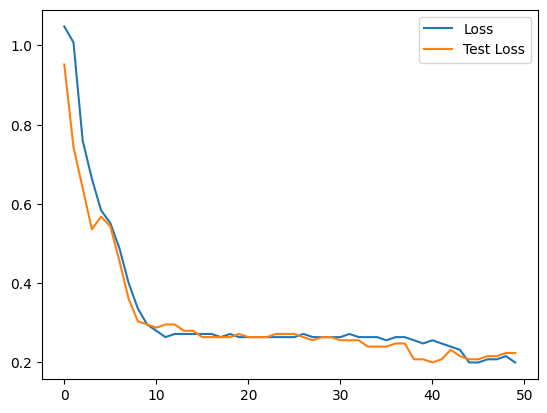

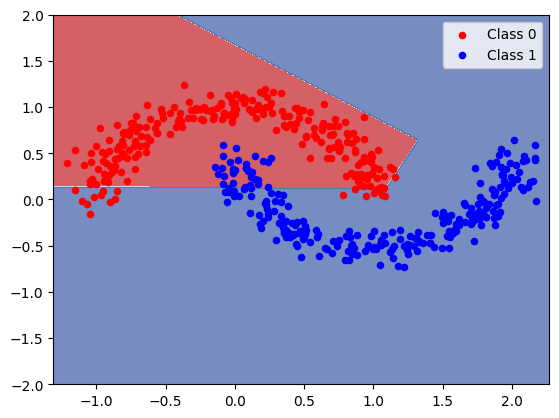

CASE FOR 5 HIDDEN LAYER NEURONS
Epoch: 0 | Loss: 0.912 | Test Loss: 0.736
Epoch: 5 | Loss: 0.432 | Test Loss: 0.44
Epoch: 10 | Loss: 0.472 | Test Loss: 0.424
Epoch: 15 | Loss: 0.408 | Test Loss: 0.384
Epoch: 20 | Loss: 0.352 | Test Loss: 0.376
Epoch: 25 | Loss: 0.296 | Test Loss: 0.264
Epoch: 30 | Loss: 0.216 | Test Loss: 0.208
Epoch: 35 | Loss: 0.248 | Test Loss: 0.336
Epoch: 40 | Loss: 0.28 | Test Loss: 0.36
Epoch: 45 | Loss: 0.248 | Test Loss: 0.344
TP = 107 TN = 109 FP = 10 FN = 24
Accuracy = 0.864
Precision = 0.9145299145299145
Recall = 0.816793893129771


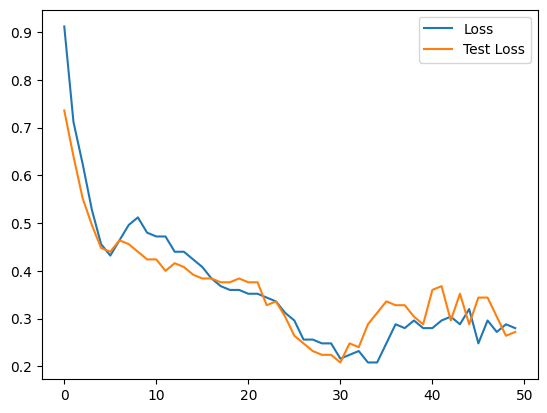

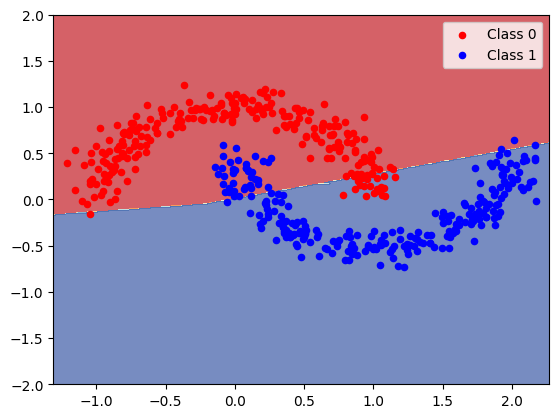

CASE FOR 8 HIDDEN LAYER NEURONS
Epoch: 0 | Loss: 1.048 | Test Loss: 0.952
Epoch: 5 | Loss: 0.504 | Test Loss: 0.536
Epoch: 10 | Loss: 0.32 | Test Loss: 0.328
Epoch: 15 | Loss: 0.296 | Test Loss: 0.296
Epoch: 20 | Loss: 0.296 | Test Loss: 0.28
Epoch: 25 | Loss: 0.28 | Test Loss: 0.28
Epoch: 30 | Loss: 0.264 | Test Loss: 0.272
Epoch: 35 | Loss: 0.264 | Test Loss: 0.264
Epoch: 40 | Loss: 0.256 | Test Loss: 0.264
Epoch: 45 | Loss: 0.24 | Test Loss: 0.264
TP = 101 TN = 117 FP = 2 FN = 30
Accuracy = 0.872
Precision = 0.9805825242718447
Recall = 0.7709923664122137


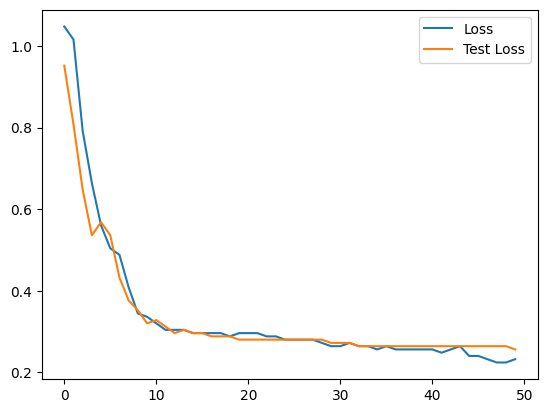

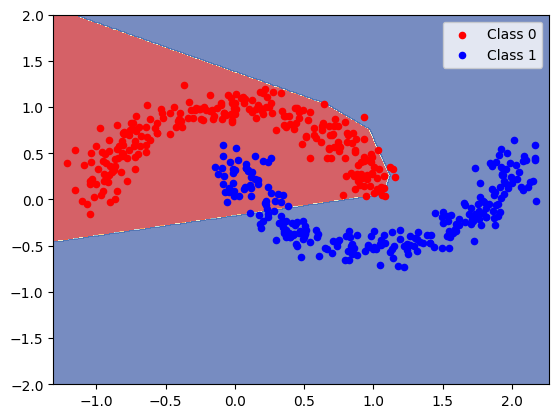

In [723]:
hidden_layer_cases = [3, 5, 8]
alpha = 0.001
epochs = 50

for case in hidden_layer_cases:
    print(f"CASE FOR {case} HIDDEN LAYER NEURONS")
    model = MadaLineMR1(X_train, X_test, y_train, y_test, (2, case, 1))

    losses, test_losses = model.fit(alpha, 0.001, epochs)

    TP, TN, FP, FN = model.get_cofusion_matrix()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print(f"TP = {TP} TN = {TN} FP = {FP} FN = {FN}")
    print(f"Accuracy = {accuracy}\nPrecision = {precision}\nRecall = {recall}")

    plt.plot(losses, label="Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.legend()
    plt.show()

    plot_decesion_boundary(model)